In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import shap
from collections import Counter
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%time
loans_data=pd.read_csv("kiva_ds_csv/loans.csv")

Wall time: 8min 9s


In [4]:
loans_data.columns = [x.lower() for x in loans_data.columns]

In [5]:
%%time
# loans_data[['POSTED_TIME','PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME']] = pd.to_datetime(loans_data[['POSTED_TIME','PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME']],infer_datetime_format=True)
loans_data[['posted_time','planned_expiration_time','disburse_time','raised_time']] = loans_data[['posted_time','planned_expiration_time','disburse_time','raised_time']].apply(pd.to_datetime)

Wall time: 7min 35s


In [303]:
%%time
#count number of loans per year from 2006 t0 2021
loans_data['posted_time'].dt.year.value_counts(sort=True)

Wall time: 230 ms


2018    229633
2017    225476
2019    219005
2016    197236
2015    181835
2020    176490
2014    174232
2021    142279
2013    140035
2012    133847
2011    113009
2010     92902
2009     81629
2008     50697
2007     26314
2006      3200
Name: posted_time, dtype: int64

In [7]:
#Dataframe shape
nrow, ncol = loans_data.shape
nrow, ncol

(2187819, 34)

In [8]:
#EDA for Categorical Variables
#%%time
ds_cat = loans_data.select_dtypes(include = 'object').copy()
ds_cat.head()

,loan_name,original_language,description,description_translated,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,Emelisa,English,Emelisa is 32 years old. With two children in...,Emelisa is 32 years old. With two children in...,funded,General Store,Retail,"to buy items to sell like beverages, canned go...",PH,Philippines,"Calbayog City 2, Samar",shared,PHP,#Woman-Owned Business,Emelisa,female,true,monthly,field_partner
1,Samol,English,Samol is married and she lives with her husban...,Samol is married and she lives with her husban...,funded,Personal Housing Expenses,Housing,to purchase construction material.,KH,Cambodia,Prek Pnov District,standard,USD,"#Repair Renew Replace, #Parent",Samol,female,true,monthly,field_partner
2,ABLA,French,Abla est une femme célibataire qui habite à Ag...,Abla is an unmarried woman living in Agoe. She...,funded,Food Production/Sales,Food,"to buy 5 sacks of corn, 2 cans of oil, and a s...",TG,Togo,Agoe,shared,XOF,"#Woman-Owned Business, user_favorite",ABLA,female,true,monthly,field_partner
3,Emanuellita,English,Emanuellita works hard to support six children...,Emanuellita works hard to support six children...,funded,Personal Housing Expenses,Housing,to build a sanitary toilet,PH,Philippines,"Cordova, Cebu",shared,PHP,"#Health and Sanitation, #Eco-friendly",Emanuellita,female,true,monthly,field_partner
4,Leizel,English,Leizel is 26 years old and married with one ch...,NaN,funded,Livestock,Agriculture,to buy livestock to raise,PH,Philippines,"Kabankalan, Negros Occidental",shared,PHP,NaN,Leizel,female,true,monthly,field_partner


In [9]:
ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in ds_cat.columns:
    tmp['column'] = [c]
    tmp['values'] = [ds_cat[c].unique()]
    tmp['values_count_incna'] = len(list(ds_cat[c].unique()))
    tmp['values_count_nona'] = int(ds_cat[c].nunique())
    tmp['num_miss'] = ds_cat[c].isnull().sum()
    tmp['pct_miss'] = (ds_cat[c].isnull().sum()/ len(ds_cat)).round(3)*100
    ds_cat_stats = ds_cat_stats.append(tmp)
    
ds_cat_stats

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,loan_name,"[Emelisa, Samol, ABLA, Emanuellita, Leizel, na...",477941,477940,50390,2.3
0,original_language,"[English, French, nan, Spanish, Russian, Portu...",9,8,46041,2.1
0,description,[Emelisa is 32 years old. With two children i...,2137257,2137256,46270,2.1
0,description_translated,[Emelisa is 32 years old. With two children i...,1728027,1728026,455656,20.8
0,status,"[funded, expired, refunded, fundRaising]",4,4,0,0.0
0,activity_name,"[General Store, Personal Housing Expenses, Foo...",163,163,0,0.0
0,sector_name,"[Retail, Housing, Food, Agriculture, Services,...",15,15,0,0.0
0,loan_use,"[to buy items to sell like beverages, canned g...",1284418,1284417,46064,2.1
0,country_code,"[PH, KH, TG, KE, PS, PK, TO, LB, CL, AM, MG, K...",99,98,36,0.0
0,country_name,"[Philippines, Cambodia, Togo, Kenya, Palestine...",99,99,0,0.0


In [10]:
#drop columns that will not be used for modeling
loans=loans_data.drop([
    'description',
    'description_translated',
    'country_code','town_name',
    'currency_exchange_coverage_rate',
    'planned_expiration_time',
    'borrower_names',
    'loan_name',
    'image_id',
    'video_id',
    'num_journal_entries',
    'num_bulk_entries',
    'tags',
    'raised_time',
    'disburse_time',
    'activity_name',
    'loan_use'],
    axis=1)

In [11]:
#rename columns
loans.rename(columns={"borrower_genders": "gender"},inplace=True)
loans.dropna(subset = ['gender'],inplace=True)

In [12]:
'''
Clean the gender column.
Some loans applications are submited by a group of people, so for this cases, we set gender "group"
'''
loans['group_gender'] = loans['gender'].map({'male':'male','female':'female'}).fillna('group')

In [13]:
loans['group_gender'].value_counts()

female    1417379
male       436449
group      287950
Name: group_gender, dtype: int64

In [14]:
#remove empty spaces and change gender column into a list
loans['gender'] = loans.gender.apply(lambda x: x.replace(' ',''))
loans['gender_list'] = loans.gender.apply(lambda x: x.split(','))

In [15]:
'''
for loans submitted by a group of people we counted the gender proportion
'the gender' of the group was assigned according to the gender of the majority
'''

loans['gender_counts'] = loans.gender_list.apply(lambda x: Counter(x))
loans['dominant_gender'] = loans.gender_counts.apply(lambda x: x.most_common(1)[0][0])
#c = Counter(loans.gender_list[1053])

In [16]:
loans.dominant_gender.value_counts()

female         1669584
male            472140
unspecified         54
Name: dominant_gender, dtype: int64

In [17]:
#drop rows where gender is unspecified
loans=loans.loc[loans['dominant_gender']!='unspecified']

In [18]:
loans.dominant_gender.value_counts()

female    1669584
male       472140
Name: dominant_gender, dtype: int64

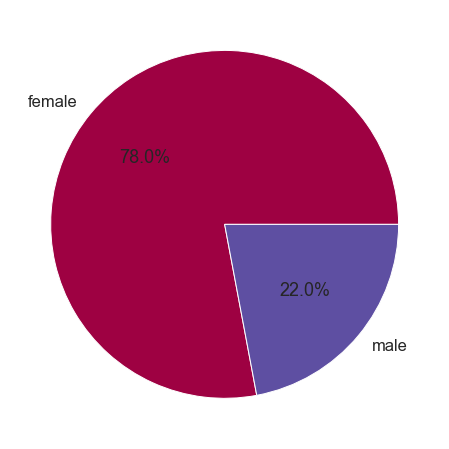

In [726]:
plt.figure(figsize = (8,8))
#fig.patch.set_facecolor('none')
sns.set(font_scale =1.5)
#ax1 = fig.add_subplot(2,2,1)
gender_dist=loans['dominant_gender'].value_counts().plot(kind='pie', autopct='%1.1f%%',cmap="Spectral")
fig = gender_dist.get_figure()
gender_dist.set( xlabel = None, ylabel = None)
plt.savefig('loan_applicants_gender_distr.png',bbox_inches = 'tight',transparent=True)

[Text(3.200000000000003, 0.5, ''), Text(0.5, 3.200000000000003, '')]

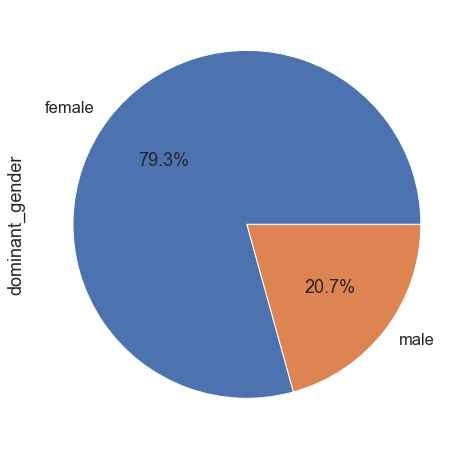

In [729]:
#gender distribution of people who were funded
plt.figure(figsize = (8,8))
#fig.patch.set_facecolor('none')
sns.set(font_scale =1.5)
#ax1 = fig.add_subplot(2,2,1)
funded_gender_dist=loans.loc[loans.status=='funded']['dominant_gender'].value_counts().plot(kind='pie', autopct='%1.1f%%',)
fig = funded_gender_dist.get_figure()
gender_dist.set( xlabel = None, ylabel = None)

In [21]:
#add indicator to show if the loan is from a group or individual
loans['borrower_type'] = np.where(loans['group_gender']== 'group', 'group', 'individual')

In [22]:
loans.borrower_type.value_counts()

individual    1853828
group          287896
Name: borrower_type, dtype: int64

In [23]:
#missing values
missing_df = pd.DataFrame(columns = ['column','num_miss', 'pct_miss'])
tmp2 = pd.DataFrame()
for c in loans.columns:
    tmp2['column'] = [c]
    tmp2['num_miss'] = loans[c].isnull().sum()
    tmp2['pct_miss'] = (loans[c].isnull().sum()/ len(loans)).round(3)*100
    missing_df = missing_df.append(tmp2)
missing_df

,column,num_miss,pct_miss
0,loan_id,0,0.0
0,original_language,0,0.0
0,funded_amount,0,0.0
0,loan_amount,0,0.0
0,status,0,0.0
0,sector_name,0,0.0
0,country_name,0,0.0
0,currency_policy,0,0.0
0,currency,0,0.0
0,partner_id,0,0.0


In [24]:
#loans['group_gender'] = loans['gender'].map({'male':'male','female':'female'}).fillna('group')
loans.lender_term.describe()
loans.dropna(subset = ['lender_term'],inplace=True)

In [25]:

print(loans.loc[loans.funded_amount==0].repayment_interval.value_counts())
#percentage of people who did not get funded
print(len(loans.loc[loans.funded_amount==0])*100/len(loans))

monthly      4297
bullet        466
irregular     150
Name: repayment_interval, dtype: int64
0.22939720782555914


In [405]:
#total amount raised
total_raised=loans.loan_amount.sum()
print('The total amount raised is',total_raised,'USD')

The total amount raised is 1736944145.0 USD


,loan_amount
count,2.141700e+06
mean,8.110119e+02
std,1.642092e+03
min,2.500000e+01
25%,2.750000e+02
50%,5.000000e+02
75%,9.500000e+02
90%,1.575000e+03
95%,2.600000e+03
99%,5.375000e+03


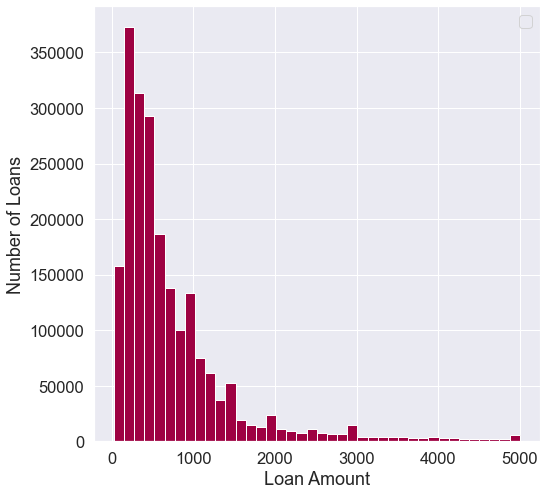

In [715]:
loan_amount_dist=pd.DataFrame(loans[['loan_amount']].describe(percentiles=[.25, .5, .75,.90,.95,.99]))
#loan_amount_dist.to_csv("Loan_amount_distribution")
loans[['loan_amount']].loc[loans.loan_amount<=5000].plot.hist(bins=40,figsize=(8,8),cmap="Spectral")
plt.xlabel('Loan Amount') 
plt.ylabel('Number of Loans')
plt.legend("")
loan_amount_dist
plt.savefig("plot_Loan_amount_distribution.png",transparent=True)
loan_amount_dist

,num_lenders_total
count,2.141700e+06
mean,2.127340e+01
std,4.385209e+01
min,0.000000e+00
25%,7.000000e+00
50%,1.300000e+01
75%,2.500000e+01
90%,4.300000e+01
95%,6.500000e+01
99%,1.320000e+02


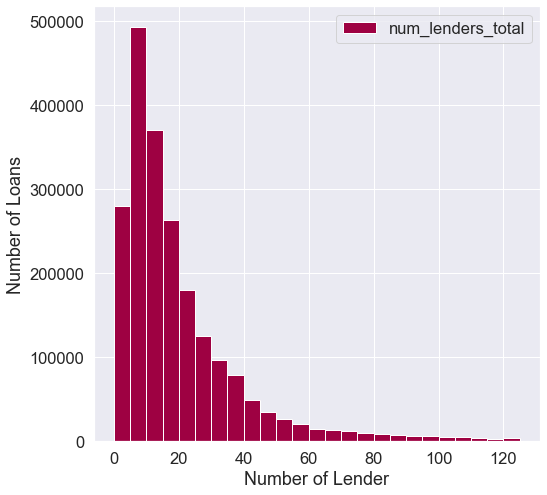

In [716]:
#distribution number of lenders
num_lenders_total_dist=pd.DataFrame(loans[['num_lenders_total']].describe(percentiles=[.25, .5, .75,.90,.95,.99]))
#num_lenders_total_dist.to_csv("Loan_amount_distribution")

loans[['num_lenders_total']].loc[loans.num_lenders_total<=125].plot.hist(bins=25,figsize=(8,8),cmap="Spectral")
plt.xlabel('Number of Lender') 
plt.ylabel('Number of Loans') 
num_lenders_total_dist
plt.savefig("plot_num_lenders_total_distribution.png",dpi=300,bbox_inches = 'tight',transparent=True)
num_lenders_total_dist

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


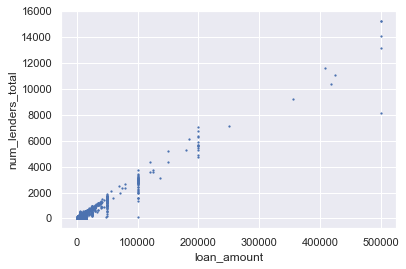

In [507]:
#loan amount vs number of lenders
loans.plot.scatter(y='num_lenders_total',x='loan_amount',s=1.5)

Only 0.22% of people did not secure any loans

In [785]:
clean_data=loans.drop(['partner_id','loan_id',
                       'posted_time',
                        'funded_amount',
                        'loan_amount',
                        'gender_counts',
                       'gender_list',
                       'group_gender',
                       'gender',
                       'borrower_pictured',
                       'original_language',
                       'num_lenders_total',
                      'lender_term',
                       'currency',
                       #'borrower_type',
                       'distribution_model',
                      ],axis=1)
clean_data.rename(columns={'dominant_gender':'gender'},inplace=True)

In [118]:
clean_data

,status,sector_name,country_name,currency_policy,repayment_interval,gender,borrower_type
0,funded,Retail,Philippines,shared,monthly,female,individual
1,funded,Housing,Cambodia,standard,monthly,female,individual
2,funded,Food,Togo,shared,monthly,female,individual
3,funded,Housing,Philippines,shared,monthly,female,individual
4,funded,Agriculture,Philippines,shared,monthly,female,individual
...,...,...,...,...,...,...,...
2187814,funded,Agriculture,Nigeria,shared,bullet,male,individual
2187815,funded,Agriculture,Mali,shared,bullet,female,group
2187816,funded,Agriculture,Nigeria,shared,bullet,male,individual
2187817,expired,Retail,El Salvador,shared,bullet,female,individual


In [786]:
# #Associate country to Region
import country_converter as coco
cc = coco.CountryConverter()
#Add column associating each country to its region
clean_data['region']=clean_data.apply(lambda row: cc.convert(names = row.country_name, to = 'UNRegion'),axis=1)

Virgin Islands not found in regex
Virgin Islands not found in regex


In [828]:
#now that we have regions, drop country column
clean_data.drop(['country_name'],axis=1,inplace=True)
#clean_data = clean_data[clean_data.region.isin(['Micronesia','not found']) == False]

In [829]:
clean_data.head()

,Unnamed: 0,status,sector_name,currency_policy,repayment_interval,gender,borrower_type,region
0,0,funded,Retail,shared,monthly,female,individual,South-Eastern Asia
1,1,funded,Housing,standard,monthly,female,individual,South-Eastern Asia
2,2,funded,Food,shared,monthly,female,individual,Western Africa
3,3,funded,Housing,shared,monthly,female,individual,South-Eastern Asia
4,4,funded,Agriculture,shared,monthly,female,individual,South-Eastern Asia


In [830]:
#number of loans per region
clean_data.region.value_counts()

South-Eastern Asia    644318
Eastern Africa        416534
South America         285331
Central America       216202
Western Africa        166402
Western Asia          112671
Central Asia           94116
Southern Asia          86852
Polynesia              27992
Middle Africa          16812
Caribbean              13929
Northern America       13582
Eastern Asia           12890
Southern Europe         9014
Melanesia               8058
Eastern Europe          7710
Northern Africa         5665
Southern Africa         3616
Name: region, dtype: int64

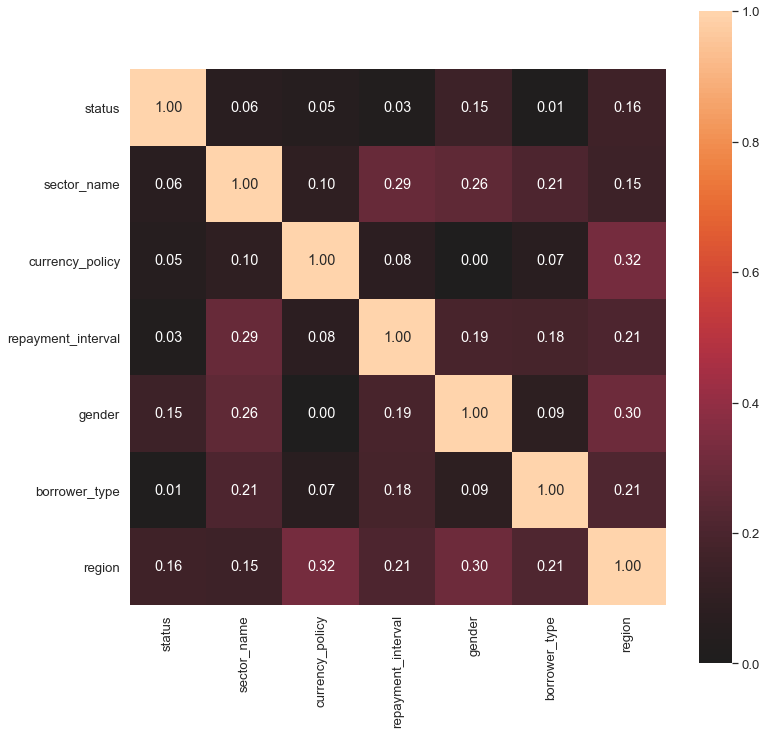

<Figure size 432x288 with 0 Axes>

In [195]:
#Check correlation between categorical variables
from dython.nominal import associations
associations(clean_data,figsize = (12,12))
plt.savefig("Correlation map.png",bbox_inches = 'tight')

In [826]:
#clean_data.info()
c#lean_data.to_csv("clean_data_kiva.csv")
clean_data=pd.read_csv("clean_data_kiva.csv")

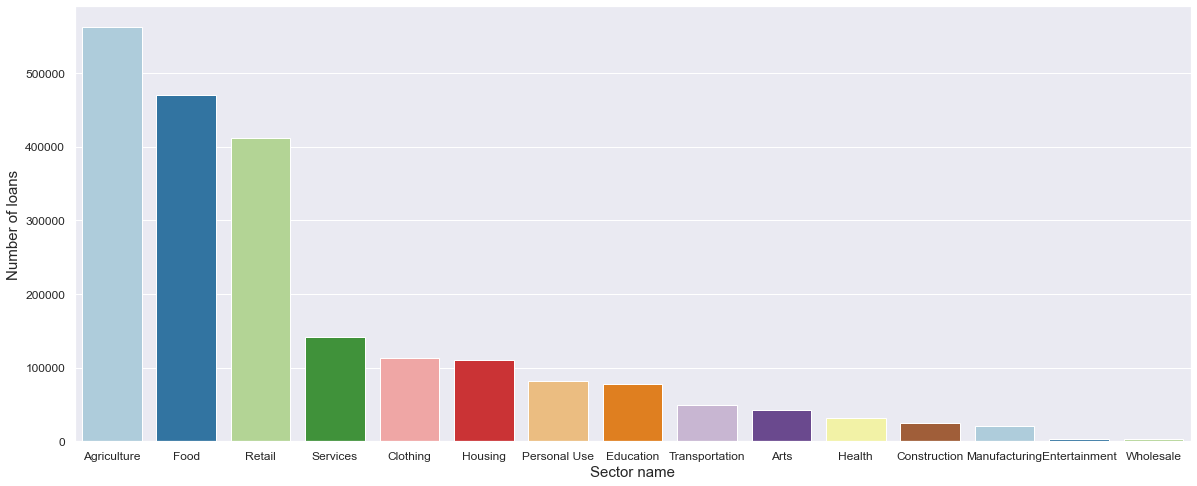

In [300]:
plt.figure(figsize=(20,8))
sns.set(font_scale =1.2)
#clean_data.sector_name.value_counts().plot(kind='pie',cmap='BuGn',autopct='%1.1f%%')
ax1=sns.countplot(x='sector_name',data=clean_data,order=clean_data.sector_name.value_counts().index,palette='Paired')
ax1.set( xlabel = "Sector name", ylabel = "Number of loans")
plt.xlabel('Sector name',size=15)
plt.ylabel('Number of loans',size=15)
plt.tick_params(labelsize=12)
plt.savefig("Sector name distr.png",bbox_inches = 'tight', transparent=True)

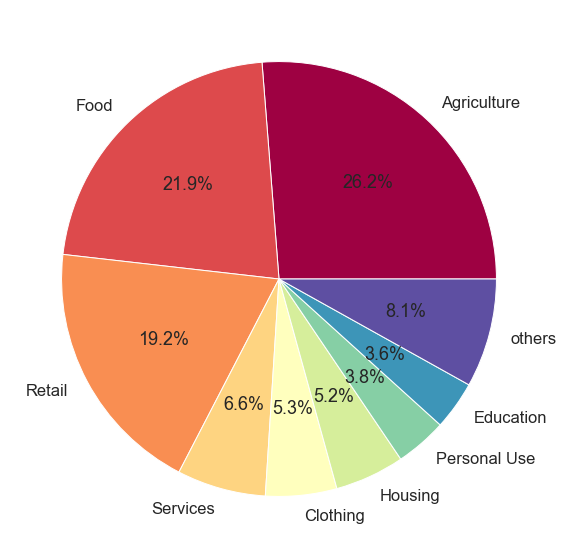

In [790]:
# clean_data.region.value_counts().plot(kind='pie',autopct='%1.1f%%')
sectors =clean_data.sector_name.unique()
#the full dataframe
dic_sec=Counter(clean_data.sector_name)
df_sec = pd.DataFrame(
    data = {'sector_name': list(dic_sec.keys()), 'value' :list(dic_sec.values())},
    ).sort_values('value', ascending = False)
#the top 5
df2_sec = df_sec[:8].copy()

#others
new_row_sec = pd.DataFrame(data = {
    'sector_name' : ['others'],
    'value' : [df_sec['value'][8:].sum()]
})

#combining top 6 with others
df2_sec = pd.concat([df2_sec, new_row_sec])
df2_sec.plot(kind = 'pie', y = 'value', labels = df2_sec['sector_name'],autopct='%1.1f%%',cmap='Spectral',figsize=(10,10))
plt.ylabel("")
plt.legend(loc='center left', bbox_to_anchor=(2, 1))
plt.legend('',frameon=False)
plt.savefig("Sector name distr.png",bbox_inches = 'tight', transparent=True)

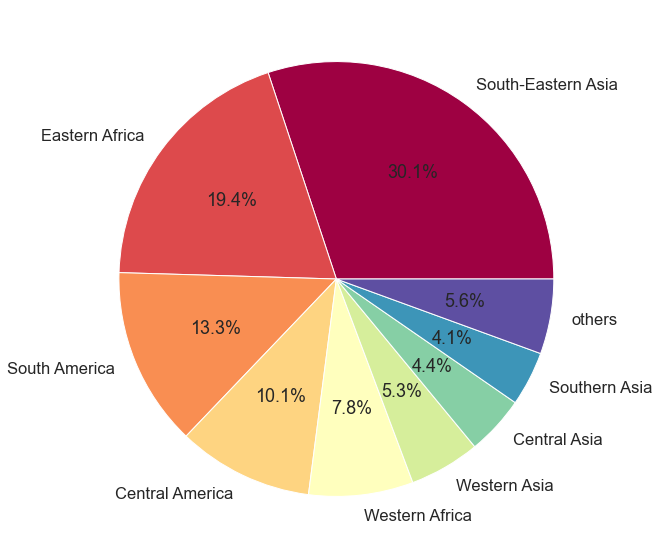

In [792]:

# clean_data.region.value_counts().plot(kind='pie',autopct='%1.1f%%')
regions =clean_data.region.unique()
regions
#the full dataframe
dic=Counter(clean_data.region)
df = pd.DataFrame(
    data = {'country': list(dic.keys()), 'value' :list(dic.values())},
    ).sort_values('value', ascending = False)
#the top 5
df2 = df[:8].copy()

#others
new_row = pd.DataFrame(data = {
    'country' : ['others'],
    'value' : [df['value'][8:].sum()]
})

#combining top 6 with others
df2 = pd.concat([df2, new_row])
df2.plot(kind = 'pie', y = 'value', labels = df2['country'],autopct='%1.1f%%',cmap='Spectral',figsize=(10,10))
plt.legend(loc='center left', bbox_to_anchor=(2, 1))
plt.ylabel("")
plt.legend('',frameon=False)
plt.savefig("Region distr.png",bbox_inches = 'tight', transparent=True)

funded         2043116
expired          93700
fundRaising       4878
Name: status, dtype: int64


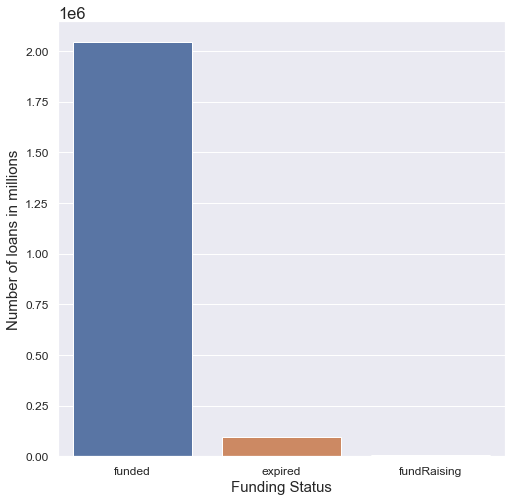

In [791]:
print(clean_data.status.value_counts())
plt.figure(figsize=(8,8))
fund_status=sns.countplot(x='status',data=clean_data)
#fund_status.set( xlabel = "Funding Status", ylabel = "Number of loans in millions")
plt.xlabel('Funding Status',size=15)
plt.ylabel('Number of loans in millions',size=15)
plt.tick_params(labelsize=12)
plt.savefig("funding_status.png",bbox_inches = 'tight',transparent=True)

In [34]:
# sns.countplot(x='distribution_model',data=clean_data, hue='gender')
# clean_data.distribution_model.unique()

In [834]:
'''
We are trying to predit the status of a loan, so what matter is if the loan has been funded or not
We are going to make "expired_status" and 'fundraising' into one category---> not_funded
funded----> 1
'''
clean_data['status'] = clean_data['status'].map({'funded':'funded','expired':'not_funded','fundRaising':'not_funded'})
# funded=clean_data.loc[clean_data.status=='funded']
# not_funded=clean_data.loc[clean_data.status!='funded']
clean_data.status.value_counts()

funded        2043116
not_funded      98578
Name: status, dtype: int64

In [835]:
#create response and explanatory datasets.
X=clean_data.drop(['status','Unnamed: 0'],axis = 1)
Y=clean_data['status']
print(X.shape,Y.shape)
Counter(Y)

(2141694, 6) (2141694,)


Counter({'funded': 2043116, 'not_funded': 98578})

In [836]:
# list containing each type of feature in our dataset
numeric=X.select_dtypes(include=np.number).columns.tolist()
categorical=X.select_dtypes(exclude=np.number).columns.tolist()

In [837]:
# count how many levels each categorical value has
for col in categorical:
    print(col,'has',clean_data[col].nunique(),'levels')

sector_name has 15 levels
currency_policy has 2 levels
repayment_interval has 3 levels
gender has 2 levels
borrower_type has 2 levels
region has 18 levels


Thre is a clear class imbalance in our dataset.
Since we already have a lot of data we will firtst try to downsample the majority class

In [838]:
#encode categorical variables
X_dum=pd.get_dummies(X,columns=categorical,drop_first=True)
Y_dum=pd.get_dummies(Y,drop_first=False)

In [839]:
Y_dum.drop(['not_funded'],axis=1,inplace=True)

In [840]:
#split data
X_train, X_test, y_train, y_test = train_test_split( X_dum,Y_dum, test_size=0.25, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1606270, 36) (535424, 36) (1606270, 1) (535424, 1)


In [ ]:
#encode categorical variables
#X_rus_dum=pd.get_dummies(X_rus_df,columns=categorical,drop_first=True)
#X_rus_dum['lender_term']
#X_rus_dum

In [841]:
# Implementing Undersampling for Handling Imbalanced 
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)
X_rus,y_rus=rus.fit_sample(X_train,y_train)

In [842]:
#put undersampled data into a dataframe
X_rus_df=pd.DataFrame(X_rus,columns=X_dum.columns)
y_rus_df=pd.DataFrame(y_rus,columns=['funded'])
#y_rus_dum=pd.get_dummies(y_rus_df,columns=['funded'],drop_first=True)


In [843]:
#distribution of funded and non funded loans after downsampling
print(y_rus_df.funded.value_counts())

1    73879
0    73879
Name: funded, dtype: int64


In [623]:
#associations(X_rus_df,figsize = (18,18))

In [133]:
#scale numeric values
#scaler=StandardScaler()
#X_train[numeric] = scaler.fit_transform(X_train[numeric])
#X_scaled=X_rus_dum

### Modeling

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Logistic regression

In [844]:
logr=LogisticRegression(penalty='l2',random_state=42,)
logr.fit(X_rus_df,y_rus_df)
y_pred_logr=logr.predict(X_test)
print(classification_report(y_test, y_pred_logr))

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


              precision    recall  f1-score   support

           0       0.11      0.72      0.19     24699
           1       0.98      0.71      0.82    510725

    accuracy                           0.71    535424
   macro avg       0.54      0.71      0.50    535424
weighted avg       0.94      0.71      0.79    535424



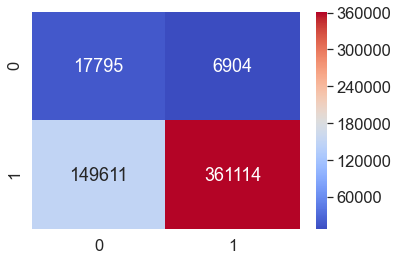

In [919]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_logr)
f = sns.heatmap(cm, annot=True, fmt='d',cmap='coolwarm')

Lets' try to adjust the threshold for logistic regression to see if we can improve the F1 score

In [845]:
#save classification report as csv
report = classification_report(y_test, y_pred_logr, output_dict=True)
log_r_report_df = pd.DataFrame(report).transpose()
log_r_report_df.to_csv('logreg_classsification_report.csv')

In [861]:
# # fit a model
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from matplotlib import pyplot
logr2 = LogisticRegression(solver='lbfgs',max_iter=1000)
logr2.fit(X_rus_df, y_rus_df.values.ravel())
# predict probabilities
yhat = logr2.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
#calculate F1 Scores
#precision, recall, thresholds = precision_recall_curve(y_test, yhat)
# get the best threshold
AUC = metrics.auc(fpr, tpr)
#ix = argmax(J)
#F1=(2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = argmax(F1)

best_thresh = thresholds[ix]
print('Best Threshold=%f, AUC-Score=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.500899, AUC-Score=0.714


In [864]:
import sklearn.metrics as metrics
y_pred_new_threshold = (logr2.predict_proba(X_test)[:,1]>=0.500899).astype(int)
print(classification_report(y_test, y_pred_new_threshold))
#print(r_auc)

              precision    recall  f1-score   support

           0       0.11      0.72      0.19     24699
           1       0.98      0.71      0.82    510725

    accuracy                           0.71    535424
   macro avg       0.54      0.71      0.50    535424
weighted avg       0.94      0.71      0.79    535424



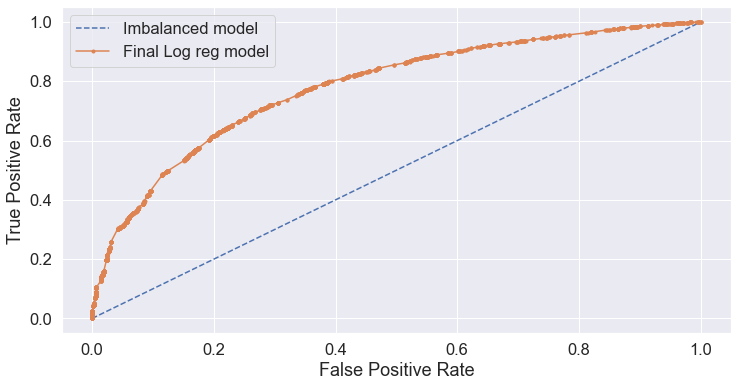

In [910]:
# plot the roc curve for the model
pyplot.figure(figsize=(12,6))
pyplot.plot([0,1], [0,1], linestyle='--', label='Imbalanced model')
pyplot.plot(fpr, tpr, marker='.', label='Final Log reg model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
#pyplot.show()
pyplot.savefig('ROC_Curve_Plot_Logistic_Regression_Model.png',transparent=True)

In [850]:
#save classification report as csv #2
report2 = classification_report(y_test, y_pred_new_threshold, output_dict=True)
log_r2_report_df = pd.DataFrame(report).transpose()
log_r2_report_df.to_csv('logreg_classsification_report_2.csv')

In [851]:
importances = pd.DataFrame(data={
    'Attribute': X_rus_df.columns,
    'Importance': logr2.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [921]:
importances.head()

,Attribute,Importance
8,sector_name_Manufacturing,3.305360
31,region_Southern Africa,2.709109
0,sector_name_Arts,1.605236
3,sector_name_Education,1.387945
14,currency_policy_standard,1.248170


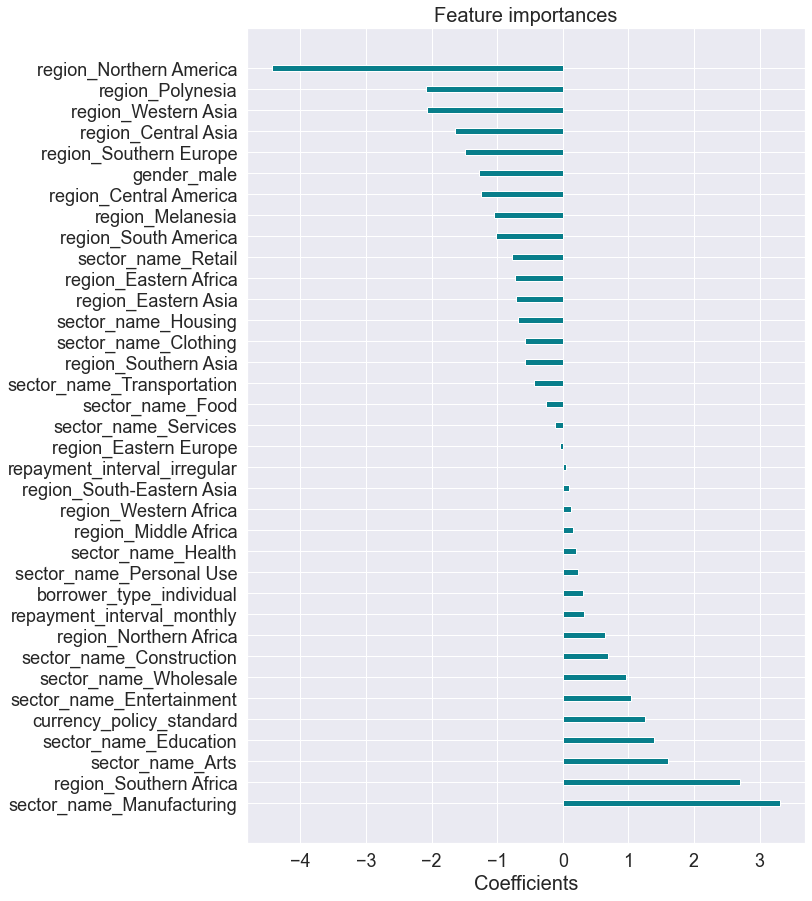

In [902]:
plt.figure(figsize=(10,15))
plt.axis('on')
#plt.bar(x=importances['Attribute'], height=importances['Importance'],width=0.3, color='#087E8B')
plt.barh(y=importances['Attribute'],width=importances['Importance'],height=0.3, color='#087E8B')
plt.title('Feature importances', size=20)

plt.grid(axis = 'both',which='major')
plt.xlabel('Coefficients',size=20)
plt.xticks(rotation='horizontal')
plt.tick_params(labelsize=18)
plt.grid(axis = 'both',which='major')
#plt.savefig("feature_importamce.png",bbox_inches = 'tight',transparent=True)

plt.show()

In [923]:
# #logistic regression using stats mode
log_reg_stats = sm.Logit(y_rus_df, X_rus_df).fit()

overflow encountered in exp
divide by zero encountered in log


Optimization terminated successfully.
         Current function value: inf
         Iterations 9


In [899]:
print(log_reg_stats.summary())


                           Logit Regression Results                           
Dep. Variable:                 funded   No. Observations:               147758
Model:                          Logit   Df Residuals:                   147722
Method:                           MLE   Df Model:                           35
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                     inf
Time:                        14:38:39   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sector_name_Arts                 1.6285      0.072     22.769      0.000       1.488       1.769
sector_name_Clothing            -0.5609      0.028    -20.223      0.000     

### Random Forrest Model

In [858]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_rus_df,y_rus_df.values.ravel())
y_pred_rf=clf.predict(X_test)

In [859]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.11      0.77      0.19     24699
           1       0.98      0.70      0.82    510725

    accuracy                           0.70    535424
   macro avg       0.55      0.74      0.51    535424
weighted avg       0.94      0.70      0.79    535424



In [908]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [909]:
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_rus_df,y_rus_df.values.ravel())

xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, xgb_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.11      0.76      0.20     24699
           1       0.98      0.71      0.83    510725

    accuracy                           0.71    535424
   macro avg       0.55      0.73      0.51    535424
weighted avg       0.94      0.71      0.80    535424



In [591]:
# from sklearn.metrics import (confusion_matrix,
#                            accuracy_score)
# yhat = log_reg.predict(X_test)
# prediction = list(map(round, yhat))
# comparing original and predicted values of y
# print('Actual values', list(y_test.values))
# print('Predictions :', prediction)
# cm = confusion_matrix(y_test, prediction)
# print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
# print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[ 18109   6684]
 [155976 354656]]
Test accuracy =  0.6962039501330719


3) KNN Classifier

In [722]:
# #KNN Classifier
# knn=KNeighborsClassifier(n_neighbors=20)
# knn.fit(X_rus_df,y_rus_df)
# y_pred_knn=knn.predict(X_test)
# print(classification_report(y_test, y_pred_knn))
# #pd.DataFrame(classification_report(y_test, y_pred_knn))

In [380]:
# #save classification report as csv
# report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
# knn_report_df = pd.DataFrame(report_knn).transpose()
# knn_report_df.to_csv('knn_classsification_report.csv')

In [51]:
# from sklearn.model_selection import GridSearchCV
# #create new a knn model
# knn2 = KNeighborsClassifier()
# #create a dictionary of all values we want to test for n_neighbors
# param_grid = {'n_neighbors': np.arange(5,25,5)}
# #use gridsearch to test all values for n_neighbors
# knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
# #fit model to data
# knn_gscv.fit(X_train,y_train)
# #check top performing n_neighbors value
# knn_gscv.best_params_
# #check mean score for the top performing value of n_neighbors
# knn_gscv.best_score_

In [52]:
# knn_gscv.best_params_